In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import torch, torchvision
import torchvision.transforms as transforms

### Make sure your runtime type is either GPU or TPU

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


The list of class names in the dataset

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

torch.Size([128, 3, 32, 32]) torch.Size([128])
cat


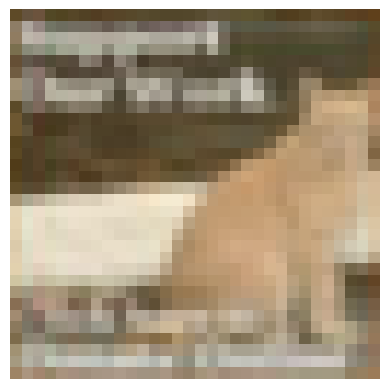

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.size(), labels.size())

i = 12
imshow(images[i].permute([1, 2, 0]).numpy()/2 + .5)
axis('off')
print(classes[labels[i].item()])



---



## Task 1
Build a neural network with two *Linear* layers and an output layer. The first Linear layer should have 512 neurons and the second 128 neurons. Both layers should use *relu* activation function. After each of these *Linear* layers, you should have a *dropout* layer (torch.nn.Dropout) with dropout probability 0.2. The output layer
should be a *Linear* layer.

Use torch.nn.CrossEntropyLoss to compute the loss value of the model output. Use *adam* optimizer to update the model parameters when training the model.

In [ ]:
model = torch.nn.Sequential(
  torch.nn.Flatten(),
  torch.nn.Linear(32*32*3, 512),
  torch.nn.ReLU(),
  torch.nn.Dropout(0.2),
  torch.nn.Linear(512, 128),
  torch.nn.ReLU(),
  torch.nn.Dropout(0.2),
  torch.nn.Linear(128, 10)
).cuda(0)


loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Task 2
Train the model for 50 epochs. Evaluate the model on the testing data. Print out the model accuracy on test data after the training.

In [ ]:
def train_epoch(model, loss_func, optimizer, trainloader):
    running_loss = 0.0
    for inputs, labels in trainloader:
        # train with one batch
        optimizer.zero_grad()
        outputs = model(inputs.cuda(0))
        loss = loss_func(outputs, labels.cuda(0))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss



for epoch in range(50):
    running_loss = train_epoch(model, loss_func, optimizer, trainloader)
    print(f'epoch: {epoch + 1} loss: {running_loss/(i+1):.3f}')

epoch: 1 loss: 54.204
epoch: 2 loss: 48.174
epoch: 3 loss: 45.727
epoch: 4 loss: 43.949
epoch: 5 loss: 42.505
epoch: 6 loss: 41.386
epoch: 7 loss: 40.296
epoch: 8 loss: 39.341
epoch: 9 loss: 38.427
epoch: 10 loss: 37.553
epoch: 11 loss: 36.883
epoch: 12 loss: 36.212
epoch: 13 loss: 35.386
epoch: 14 loss: 34.764
epoch: 15 loss: 34.149
epoch: 16 loss: 33.460
epoch: 17 loss: 32.989
epoch: 18 loss: 32.374
epoch: 19 loss: 31.782
epoch: 20 loss: 31.403
epoch: 21 loss: 30.733
epoch: 22 loss: 30.174
epoch: 23 loss: 29.739
epoch: 24 loss: 29.257
epoch: 25 loss: 28.780
epoch: 26 loss: 28.225
epoch: 27 loss: 27.896
epoch: 28 loss: 27.322
epoch: 29 loss: 26.974
epoch: 30 loss: 26.532
epoch: 31 loss: 26.235
epoch: 32 loss: 25.771
epoch: 33 loss: 25.322
epoch: 34 loss: 24.921
epoch: 35 loss: 24.467
epoch: 36 loss: 24.218
epoch: 37 loss: 23.713
epoch: 38 loss: 23.402
epoch: 39 loss: 22.928
epoch: 40 loss: 22.726
epoch: 41 loss: 22.333
epoch: 42 loss: 22.034
epoch: 43 loss: 21.796
epoch: 44 loss: 21.4

In [ ]:
def compute_acc(model, dloader):
    score = 0
    n = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dloader:
            outputs = model(inputs.cuda(0))
            pred = torch.argmax(outputs, dim=1)
            score += torch.sum(pred == labels.cuda(0)).item()
            n += labels.size()[0]
    model.train()

    acc = score/n
    return acc


acc = compute_acc(model, testloader)
print('acc =', acc)

acc = 0.5662


## Task 3
Implement a function *recognize*. It takes an image (shape = 3, 32, 32) as an input and use the "model" you trained above to make a prediction of the image's class. Your function should return the predicted (string) class (use the classes list above to map numeric prediction to string label).

Neural network recognizes this image as: cat
true image label: cat


(-0.5, 31.5, 31.5, -0.5)

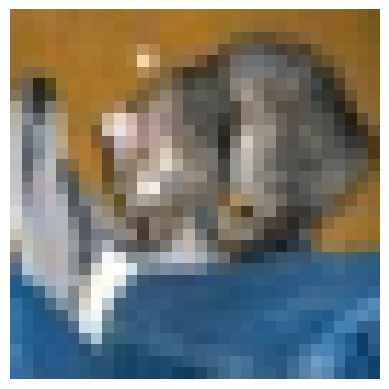

In [ ]:
def recognize(new_img):
    outputs = model(torch.unsqueeze(new_img, dim=0))
    pred = torch.argmax(outputs, dim=1)[0]
    return classes[pred.item()]


dataiter = iter(testloader)
images, labels = next(dataiter)
new_img = images[0]

pred = recognize(new_img.cuda(0))

print('Neural network recognizes this image as:', pred)
print('true image label:', classes[labels[0].item()])
imshow(new_img.permute([1, 2, 0]).numpy()/2 + .5)
axis('off')

### Task 4

Implement a CNN with the following structure:
- 4 Conv layers:  
(3x3)x32, (3x3)x32, (3x3)x64, (3x3)x64

- 2x2 Maxpool after 2nd and 4th conv.
- Dropout after pooling
- One FC layer and then a FC output layer

Train the CNN model until training accuracy converges.
(Compute accuracy on training data at the end of each epoch. Plot the accuracy values vs epochs to determine whether it converges.) Test the accuracy of the trained model on the testing dataset.

In [ ]:
cnn_model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Dropout(p=0.15),

    torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 64, kernel_size=3, padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Dropout(p=0.15),

    torch.nn.Flatten(),
    torch.nn.Linear(64 * 8 * 8, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10)
).cuda(0)


cnn_loss_func = torch.nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)

In [ ]:
acc = []
for epoch in range(50):
    running_loss = train_epoch(cnn_model, cnn_loss_func, cnn_optimizer, trainloader)
    tacc = compute_acc(cnn_model, trainloader)
    acc.append(tacc)
    print(f'epoch: {epoch + 1} loss: {running_loss/(i+1):.3f}, train acc: {tacc:.3f}')

epoch: 1 loss: 15.841, train acc: 0.316
epoch: 2 loss: 13.546, train acc: 0.399
epoch: 3 loss: 12.261, train acc: 0.446
epoch: 4 loss: 11.593, train acc: 0.467
epoch: 5 loss: 11.130, train acc: 0.487
epoch: 6 loss: 10.834, train acc: 0.501
epoch: 7 loss: 10.559, train acc: 0.513
epoch: 8 loss: 10.326, train acc: 0.522
epoch: 9 loss: 10.091, train acc: 0.532
epoch: 10 loss: 9.910, train acc: 0.547
epoch: 11 loss: 9.723, train acc: 0.558
epoch: 12 loss: 9.560, train acc: 0.563
epoch: 13 loss: 9.399, train acc: 0.575
epoch: 14 loss: 9.231, train acc: 0.578
epoch: 15 loss: 9.094, train acc: 0.586
epoch: 16 loss: 8.979, train acc: 0.596
epoch: 17 loss: 8.841, train acc: 0.602
epoch: 18 loss: 8.712, train acc: 0.611
epoch: 19 loss: 8.600, train acc: 0.616
epoch: 20 loss: 8.484, train acc: 0.621
epoch: 21 loss: 8.392, train acc: 0.625
epoch: 22 loss: 8.293, train acc: 0.628
epoch: 23 loss: 8.172, train acc: 0.636
epoch: 24 loss: 8.038, train acc: 0.646
epoch: 25 loss: 7.945, train acc: 0.651


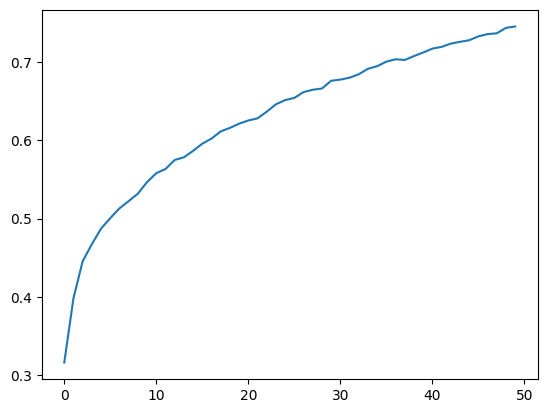

In [ ]:
plot(acc)

In [ ]:
print('acc=', compute_acc(cnn_model, testloader))

acc= 0.6947
